# Evaluate predictions of emergency demand

The previous notebook demonstrated the full implementation in code of training models for use at UCLH using the functions provided in `patientflow`. 

The final step is to evaluate the predicted distributions against observed numbers. I will evaluate the predictions by specialty, using the qq plot approach covered in a previous notebook.

As the predictions for yet-to-arrive patients are aspirational, these cannot be evaluated against observed numbers of admissions in the prediction window. Similarly for the group of patients in the ED, we calculate the predicted number of beds needed within the prediction window, but due to poor ED performance, few may have been admitted within the window.

We can, however, evaluate the predictions of beds needed for each specialty against observed numbers admitted to each specialty from among patients comprising each group snapshot. 

## Set up the notebook environment

In [1]:
# Reload functions every time
%load_ext autoreload 
%autoreload 2

In [2]:
from patientflow.load import set_project_root
project_root = set_project_root()


Inferred project root: /Users/zellaking/Repos/patientflow


## Set file paths and load data

I'm going to use real patient data from UCLH to demonstrate the implementation. 

You can request the datasets that are used here on [Zenodo](https://zenodo.org/records/14866057). Alternatively you can use the synthetic data that has been created from the distributions of real patient data. If you don't have the public data, change the argument in the cell below from `data_folder_name='data-public'` to `data_folder_name='data-synthetic'`.

In [3]:
from patientflow.load import set_file_paths

# set file paths
data_folder_name = 'data-public'
data_file_path = project_root / data_folder_name

data_file_path, media_file_path, model_file_path, config_path = set_file_paths(
    project_root, 
    data_folder_name=data_folder_name,
    config_file = 'config.yaml')

Configuration will be loaded from: /Users/zellaking/Repos/patientflow/config.yaml
Data files will be loaded from: /Users/zellaking/Repos/patientflow/data-public
Trained models will be saved to: /Users/zellaking/Repos/patientflow/trained-models/public
Images will be saved to: /Users/zellaking/Repos/patientflow/trained-models/public/media


In [5]:
import pandas as pd
from patientflow.load import load_data

# load ED snapshots data
ed_visits = load_data(data_file_path, 
                    file_name='ed_visits.csv', 
                    index_column = 'snapshot_id',
                    sort_columns = ["visit_number", "snapshot_date", "prediction_time"], 
                    eval_columns = ["prediction_time", "consultation_sequence", "final_sequence"])
ed_visits.snapshot_date = pd.to_datetime(ed_visits.snapshot_date).dt.date



## Set modelling parameters

The parameters are used in training or inference. They are set in config.json in the root of the repository and loaded by `load_config_file()`

In [6]:
# load params
from patientflow.load import load_config_file
params = load_config_file(config_path)

start_training_set, start_validation_set, start_test_set, end_test_set = params["start_training_set"], params["start_validation_set"], params["start_test_set"], params["end_test_set"]


## Apply temporal splits

In [7]:
from patientflow.prepare import create_temporal_splits

train_visits_df, valid_visits_df, test_visits_df = create_temporal_splits(
    ed_visits,
    start_training_set,
    start_validation_set,
    start_test_set,
    end_test_set,
    col_name="snapshot_date",
)


Split sizes: [53801, 6519, 19494]


## Train models to predict bed count distributions for patients currently in the ED

This time I'll use a larger parameter grid, while still limiting the search space to a few hyperparameters for expediency.

In [9]:

from patientflow.train.classifiers import train_classifier
from patientflow.load import get_model_key

grid = { # Current parameters
    'n_estimators': [30, 40, 50],  # Number of trees
    'subsample': [0.7, 0.8, 0.9],  # Sample ratio of training instances
    'colsample_bytree': [0.7, 0.8, 0.9],  # Sample ratio of columns for each tree
   } 

exclude_from_training_data = [ 'snapshot_date', 'prediction_time','visit_number', 'consultation_sequence', 'specialty', 'final_sequence', ]

ordinal_mappings = {
    "latest_acvpu": ["A", "C", "V", "P", "U"],
    "latest_obs_manchester_triage_acuity": [
        "Blue",
        "Green",
        "Yellow",
        "Orange",
        "Red",
    ],
    "latest_obs_objective_pain_score": [
        "Nil",
        "Mild",
        "Moderate",
        "Severe\\E\\Very Severe",
    ],
    "latest_obs_level_of_consciousness": ["A", "C", "V", "P", "U"],
}

# create a dictionary to store the trained models
admissions_models = {}
model_name = 'admissions'

# Loop through each prediction time
for prediction_time in ed_visits.prediction_time.unique():
    print(f"Training model for {prediction_time}")
    model = train_classifier(
        train_visits=train_visits_df,
        valid_visits=valid_visits_df,
        test_visits=test_visits_df,
        grid=grid,
        exclude_from_training_data=exclude_from_training_data,
        ordinal_mappings=ordinal_mappings,
        prediction_time=prediction_time,
        visit_col="visit_number",
        calibrate_probabilities=True,
        calibration_method="isotonic",
        use_balanced_training=True,
    )
    model_key = get_model_key(model_name, prediction_time)
    
    admissions_models[model_key] = model

Training model for (12, 0)
Training model for (15, 30)
Training model for (6, 0)
Training model for (9, 30)
Training model for (22, 0)


## Train specialty model

Here the `apply_special_category_filtering` parameter has been set to True, so it will be assumed that all patients under 18 on arrival will be admitted to a paediatric specialty. 

In [10]:
from patientflow.predictors.sequence_predictor import SequencePredictor

spec_model = SequencePredictor(
    input_var="consultation_sequence",
    grouping_var="final_sequence",
    outcome_var="specialty",
    apply_special_category_filtering=True,
)

spec_model = spec_model.fit(train_visits_df)

In [11]:
spec_model.special_params

{'special_category_func': <bound method SpecialCategoryParams.special_category_func of <patientflow.prepare.SpecialCategoryParams object at 0x287e46960>>,
 'special_category_dict': {'medical': 0.0,
  'surgical': 0.0,
  'haem/onc': 0.0,
  'paediatric': 1.0},
 'special_func_map': {'paediatric': <bound method SpecialCategoryParams.special_category_func of <patientflow.prepare.SpecialCategoryParams object at 0x287e46960>>,
  'default': <bound method SpecialCategoryParams.opposite_special_category_func of <patientflow.prepare.SpecialCategoryParams object at 0x287e46960>>}}

## Generate predicted distributions for each specialty and prediction time

As we are treating paediatric patients differently from adults, the logic below is designed to identify eligible snapshots in either case. 

When evaluating the predictions for adult destinations (medical, surgical and haem/onc), patients under 18 will be excluded. When evaluating the predictions for paediatric patients, adults will be excluded.

In [18]:
test_visits_df[test_visits_df.age_group == '0-17']['specialty_prob'].head()

snapshot_id
60177    {'medical': 0.0, 'surgical': 0.0, 'paediatric'...
60339    {'medical': 0.0, 'surgical': 0.0, 'paediatric'...
60361    {'medical': 0.0, 'surgical': 0.0, 'paediatric'...
60420    {'medical': 0.0, 'surgical': 0.0, 'paediatric'...
60421    {'medical': 0.0, 'surgical': 0.0, 'paediatric'...
Name: specialty_prob, dtype: object

In [19]:
test_visits_df[test_visits_df.age_group != '0-17']['specialty_prob'].head()

snapshot_id
2        {'medical': 0.6513468480977506, 'surgical': 0....
55916    {'medical': 0.05485232067510548, 'surgical': 0...
55917    {'medical': 0.05485232067510548, 'surgical': 0...
55918    {'medical': 0.05485232067510548, 'surgical': 0...
58564    {'medical': 0.13205417607223477, 'surgical': 0...
Name: specialty_prob, dtype: object

In [49]:
from patientflow.prepare import prepare_patient_snapshots, prepare_group_snapshot_dict
from patientflow.aggregate import get_prob_dist
from patientflow.predict.emergency_demand import get_specialty_probs

prob_dist_dict_all = {}
specialties = ['medical', 'surgical', 'haem/onc', 'paediatric']

special_params = spec_model.special_params

special_category_func = special_params["special_category_func"]
special_category_dict = special_params["special_category_dict"]
special_func_map = special_params["special_func_map"]

# Get predictions of admission to specialty
test_visits_df.loc[:, "specialty_prob"] = get_specialty_probs(
    specialties,
    spec_model,
    test_visits_df,
    special_category_func=special_category_func,
    special_category_dict=special_category_dict,
)

# initialise a dictionary to store the probability distributions for each specialty and prediction time
prob_dist_dict_all = {}

# Process each time of day
for _prediction_time in ed_visits.prediction_time.unique():

    prob_dist_dict_for_prediction_time = {}

    print("\nProcessing :" + str(_prediction_time))
    model_key = get_model_key(model_name, _prediction_time)
    
    for specialty in specialties:
        print(f"Predicting bed counts for {specialty} specialty, for all snapshots in the test set")
        prob_dist_dict_for_specialty = {}

        # Get indices of patients who are eligible for this specialty
        func = special_func_map.get(specialty, special_func_map["default"])
        non_zero_indices = test_visits_df[
            test_visits_df.apply(func, axis=1)
        ].index

        test_df_eligible = test_visits_df.copy()
        test_df_eligible = test_df_eligible.loc[non_zero_indices]

        # get the probability of admission to the specialty for eligible patients
        # for patients under 18, the probability of admission to paediatric is 1
        prob_admission_to_specialty = test_df_eligible["specialty_prob"].apply(
            lambda x: x[specialty]
        )

        # Prepare patient snapshots for the eligible patients
        X_test, y_test = prepare_patient_snapshots(
            df=test_df_eligible, 
            prediction_time=_prediction_time, 
            single_snapshot_per_visit=False,
            exclude_columns=exclude_from_training_data, 
            visit_col='visit_number'
        )

        # filter the probability of admission to the specialty for the eligible patients
        filtered_prob_admission_to_specialty = prob_admission_to_specialty.loc[
            non_zero_indices
        ]

        group_snapshots_dict = prepare_group_snapshot_dict(
            test_df_eligible[test_df_eligible.prediction_time == _prediction_time]
        )

        # get probability distribution for this time of day, for this specialty
        prob_dist_dict_for_prediction_time[specialty] = get_prob_dist(
            group_snapshots_dict, X_test, y_test, admissions_models[model_key], 
            weights=filtered_prob_admission_to_specialty
            ) 
        
    prob_dist_dict_all[model_key] = prob_dist_dict_for_prediction_time


Processing :(12, 0)
Predicting bed counts for medical specialty, for all snapshots in the test set
Predicting bed counts for surgical specialty, for all snapshots in the test set
Predicting bed counts for haem/onc specialty, for all snapshots in the test set
Predicting bed counts for paediatric specialty, for all snapshots in the test set

Processing :(15, 30)
Predicting bed counts for medical specialty, for all snapshots in the test set
Predicting bed counts for surgical specialty, for all snapshots in the test set
Predicting bed counts for haem/onc specialty, for all snapshots in the test set
Predicting bed counts for paediatric specialty, for all snapshots in the test set

Processing :(6, 0)
Predicting bed counts for medical specialty, for all snapshots in the test set
Predicting bed counts for surgical specialty, for all snapshots in the test set
Predicting bed counts for haem/onc specialty, for all snapshots in the test set
Predicting bed counts for paediatric specialty, for all 

## Plot qq plots for each specialty and prediction time

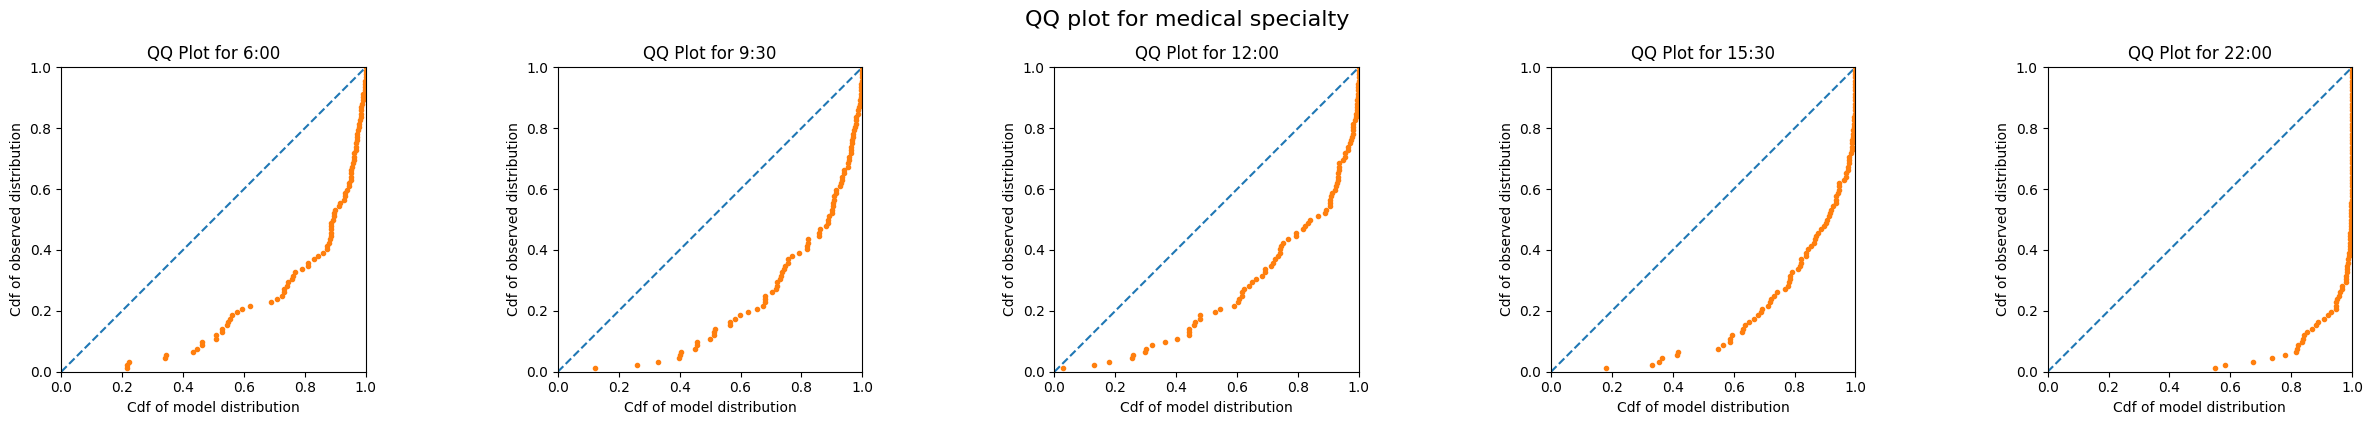

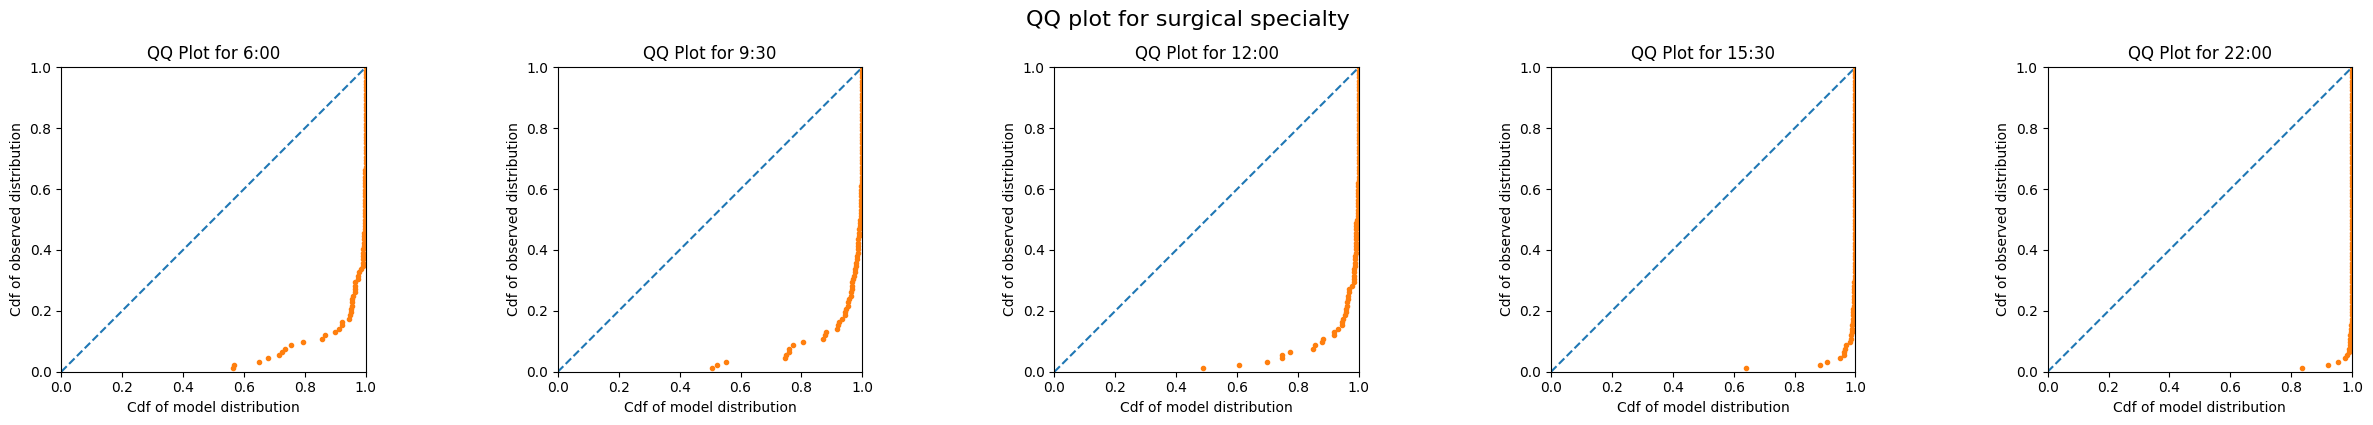

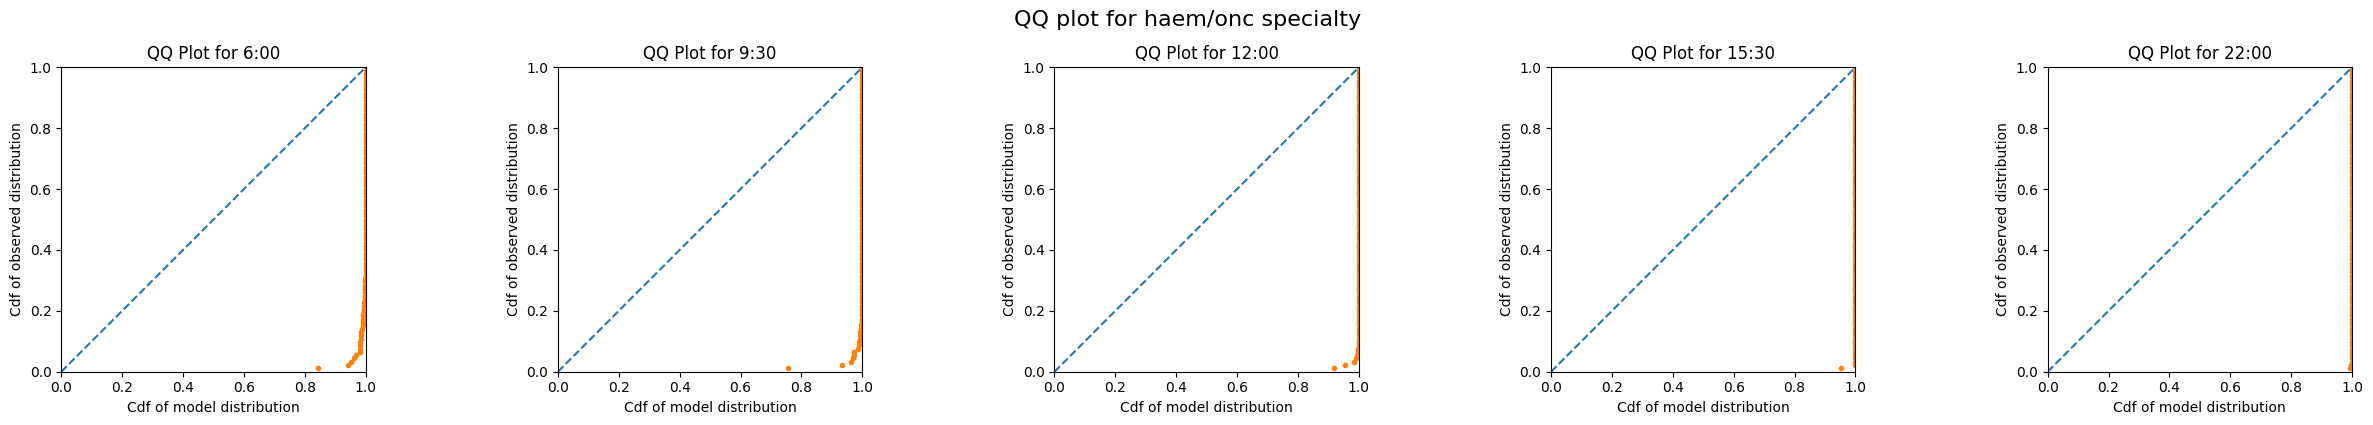

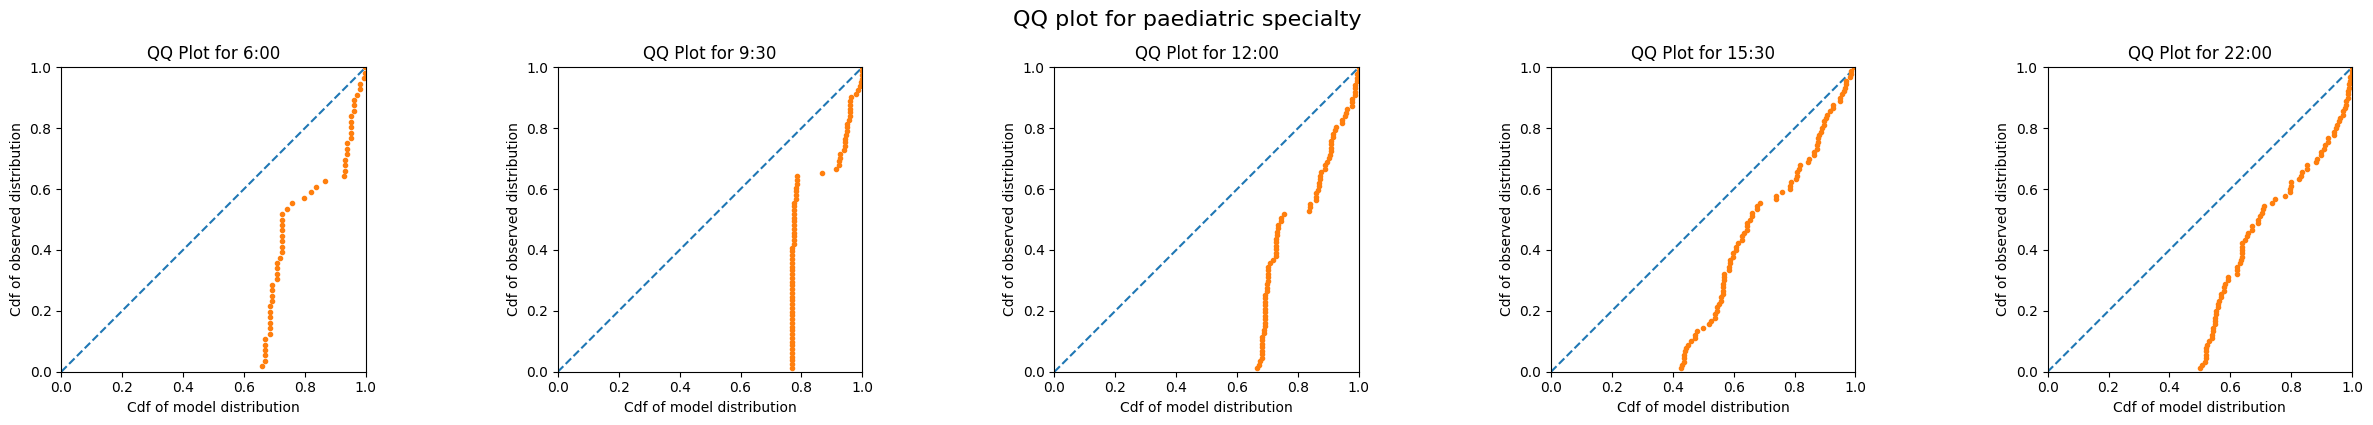

In [51]:
from patientflow.viz.qq_plot import qq_plot

for specialty in specialties:

    specialty_prob_dist = {time: dist_dict[specialty] for time, dist_dict in prob_dist_dict_all.items()}

    qq_plot(ed_visits.prediction_time.unique(), 
            specialty_prob_dist,
            model_name="admissions",
            suptitle=f"QQ plot for {specialty} specialty")

## Conclusion

This notebooks shows one method to evaluate predicted bed counts for the patients in ED. I demonstrated some of the special case handling that is in use for paediatric patients at UCLH. 

The QQ plots demonstrate that models consistently underpredict. There are a number of possible reasons, which merit further investigation. 

* The admissions model was trained on all patients, and in an earlier notebook I showed using MADCAP that discrimination and calibration were poor for patients under 18
* The method used to predict admission by specialty (consult requests while in the ED may not be robust enough)
* The assumption of independence between probability of admission, and probability of admission to a given specialty if admitted, may not hold
* The training dataset is relatively small - only six months for this public dataset; a longer period may yield better results. 

Nonetheless, the use of QQ plot visualisations for evaluating such predictions are very valuable. 